In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

In [ ]:

%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
print(tf.__version__)

2.9.2


In [ ]:

imagepaths = []

for root, dirs, files in os.walk("mydrive/My Drive/DCGAN/", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): 
      imagepaths.append(path)

print(len(imagepaths)) 

1005


In [ ]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (28, 28))
  X.append(img)
  

  category = path.split("/")[3]
  label = int(category.split(" ")[1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 232, 424, 3) # 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1005
Labels loaded:  1005
4 mydrive/My Drive/DCGAN/Class 4/11.png


In [ ]:
ts = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=43)

In [ ]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

((804, 28, 28), (201, 28, 28))

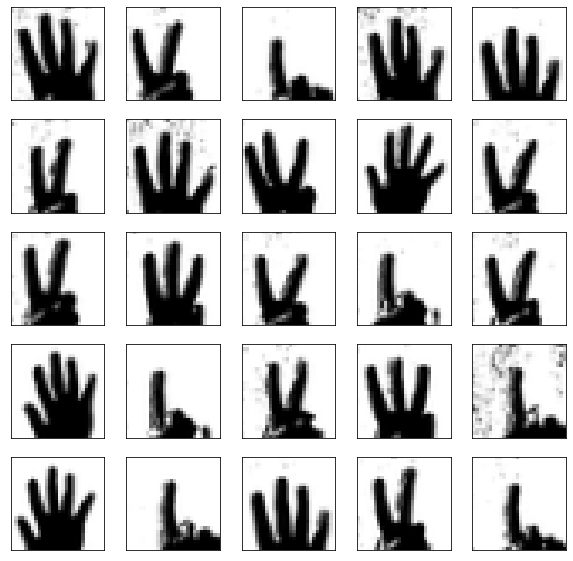

In [ ]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [ ]:

batch_size = 32

def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
 
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  return dataset

In [ ]:


num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)            

In [ ]:


discriminator.compile(loss ="binary_crossentropy", optimizer ="adam", metrics=['binary_accuracy'])
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss ="binary_crossentropy", optimizer ="adam" ,metrics=['binary_accuracy'])

In [ ]:
from numpy.random import random
from numpy.random import choice

def noisy_labels(p_flip, y):
 # determine the number of labels to flip
 n_select = int(p_flip * len(y))
 flip_ix = choice([i for i in range(len(y))], size=n_select)
 for i in flip_ix:
		y[i][0]= 1 - y[i][0]
		if(y[i][0]<0.1):
			y[i][0]=0
		
 return y
#///////////////////////
seed = tf.random.normal(shape =[batch_size, 100])
D_loss=[]
D_acc=[]
G_acc=[]
G_loss=[]
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
	generator, discriminator = gan.layers
	for epoch in range(epochs):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# نویز  * 100
			# دادن نویز به شبکه مولد
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)
			# یک دسته از تصاویر واقعی و ساختگی می سازیم
			# از آن ها برای آموزش شبکه تفکیک کننده استفاده می کنیم
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y_fake=([[1.]] * batch_size)
			y_fake_smooth= [[x[0] + -0.1 +(random() * 0.2)] for x in y_fake]
			y_fake_smooth_noise=noisy_labels(0.05,y_fake_smooth)

			y_real=([[0.]] * batch_size)
			y_real_no_smooth=[[x[0]] for x in y_real]
			y_real_noise=noisy_labels(0.05,y_real_no_smooth)
			y1 = tf.constant(y_real_noise + y_fake_smooth_noise)
	 		# flip labels with 5% probability
			discriminator.trainable = True
			d_loss,d_acc=discriminator.train_on_batch(X_fake_and_real, y1)
			D_loss.append(d_loss)
			D_acc.append(d_acc)
			# تصویر ساخته شده توسط شبکه مولد را با لیبل 1 به شبکه تفکیک کننده می دهیم
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			g_loss,g_acc=gan.train_on_batch(noise, y2)
			G_loss.append(g_loss)
			G_acc.append(g_acc)
	 		

		print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, epochs, D_loss[-1], G_loss[-1]), 100*' ')
		if epoch % 5 == 0:
			samples = 10
			x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, num_features)))

			for k in range(samples):
				plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
				plt.imshow(x_fake[k, :, :, 0] * 127.5 + 127.5, cmap ='binary')


			plt.tight_layout()
			plt.show()

	#generate_and_save_images(generator, epochs, seed)



Epoch 1/50
epoch = 1/50, d_loss=0.346, g_loss=1.851                                                                                                     
1/1 [==============================] - 0s 83ms/step


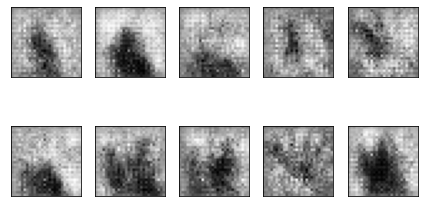


Epoch 2/50
epoch = 2/50, d_loss=0.410, g_loss=2.709                                                                                                     

Epoch 3/50
epoch = 3/50, d_loss=0.845, g_loss=1.508                                                                                                     

Epoch 4/50
epoch = 4/50, d_loss=0.863, g_loss=2.068                                                                                                     

Epoch 5/50
epoch = 5/50, d_loss=0.240, g_loss=3.594                                                                                                     

Epoch 6/50
epoch = 6/50, d_loss=0.350, g_loss=3.380                                                                                                     
1/1 [==============================] - 0s 13ms/step


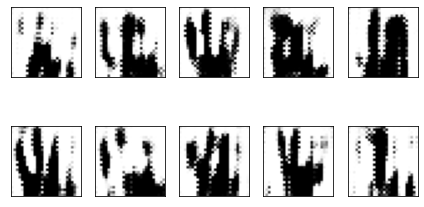


Epoch 7/50
epoch = 7/50, d_loss=0.295, g_loss=2.716                                                                                                     

Epoch 8/50
epoch = 8/50, d_loss=0.341, g_loss=2.604                                                                                                     

Epoch 9/50
epoch = 9/50, d_loss=0.221, g_loss=3.643                                                                                                     

Epoch 10/50
epoch = 10/50, d_loss=0.214, g_loss=3.416                                                                                                     

Epoch 11/50
epoch = 11/50, d_loss=0.183, g_loss=3.328                                                                                                     
1/1 [==============================] - 0s 13ms/step


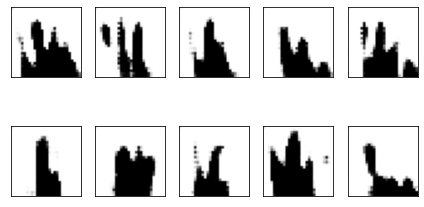


Epoch 12/50
epoch = 12/50, d_loss=0.143, g_loss=3.224                                                                                                     

Epoch 13/50
epoch = 13/50, d_loss=0.245, g_loss=4.108                                                                                                     

Epoch 14/50
epoch = 14/50, d_loss=0.216, g_loss=2.876                                                                                                     

Epoch 15/50
epoch = 15/50, d_loss=0.423, g_loss=2.093                                                                                                     

Epoch 16/50
epoch = 16/50, d_loss=0.516, g_loss=1.406                                                                                                     
1/1 [==============================] - 0s 13ms/step


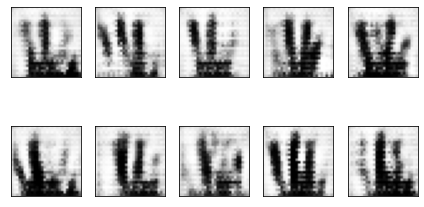


Epoch 17/50
epoch = 17/50, d_loss=0.419, g_loss=2.268                                                                                                     

Epoch 18/50
epoch = 18/50, d_loss=0.497, g_loss=2.137                                                                                                     

Epoch 19/50
epoch = 19/50, d_loss=0.440, g_loss=1.517                                                                                                     

Epoch 20/50
epoch = 20/50, d_loss=0.352, g_loss=2.527                                                                                                     

Epoch 21/50
epoch = 21/50, d_loss=0.250, g_loss=2.756                                                                                                     
1/1 [==============================] - 0s 14ms/step


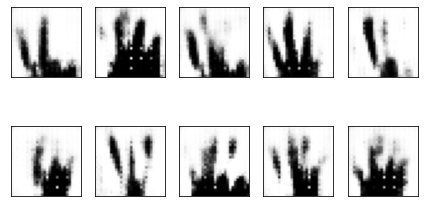


Epoch 22/50
epoch = 22/50, d_loss=0.591, g_loss=1.740                                                                                                     

Epoch 23/50
epoch = 23/50, d_loss=0.426, g_loss=1.551                                                                                                     

Epoch 24/50
epoch = 24/50, d_loss=0.476, g_loss=1.710                                                                                                     

Epoch 25/50
epoch = 25/50, d_loss=0.434, g_loss=2.451                                                                                                     

Epoch 26/50
epoch = 26/50, d_loss=0.337, g_loss=2.774                                                                                                     
1/1 [==============================] - 0s 13ms/step


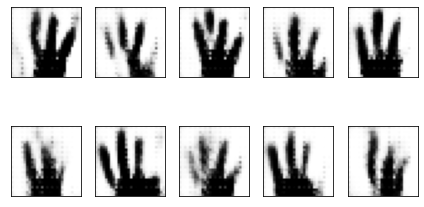


Epoch 27/50
epoch = 27/50, d_loss=0.385, g_loss=2.380                                                                                                     

Epoch 28/50
epoch = 28/50, d_loss=0.375, g_loss=2.647                                                                                                     

Epoch 29/50
epoch = 29/50, d_loss=0.294, g_loss=3.150                                                                                                     

Epoch 30/50
epoch = 30/50, d_loss=0.436, g_loss=2.498                                                                                                     

Epoch 31/50
epoch = 31/50, d_loss=0.550, g_loss=2.188                                                                                                     
1/1 [==============================] - 0s 13ms/step


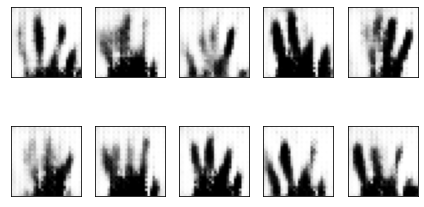


Epoch 32/50
epoch = 32/50, d_loss=0.482, g_loss=1.999                                                                                                     

Epoch 33/50
epoch = 33/50, d_loss=0.609, g_loss=1.216                                                                                                     

Epoch 34/50
epoch = 34/50, d_loss=0.492, g_loss=1.725                                                                                                     

Epoch 35/50
epoch = 35/50, d_loss=0.494, g_loss=2.085                                                                                                     

Epoch 36/50
epoch = 36/50, d_loss=0.434, g_loss=2.096                                                                                                     
1/1 [==============================] - 0s 16ms/step


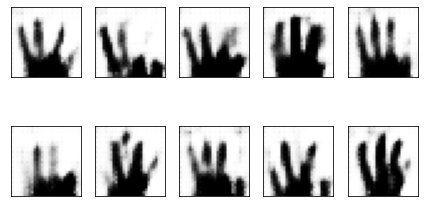


Epoch 37/50
epoch = 37/50, d_loss=0.630, g_loss=1.380                                                                                                     

Epoch 38/50
epoch = 38/50, d_loss=0.488, g_loss=1.958                                                                                                     

Epoch 39/50
epoch = 39/50, d_loss=0.424, g_loss=1.517                                                                                                     

Epoch 40/50
epoch = 40/50, d_loss=0.277, g_loss=3.334                                                                                                     

Epoch 41/50
epoch = 41/50, d_loss=0.365, g_loss=3.087                                                                                                     
1/1 [==============================] - 0s 16ms/step


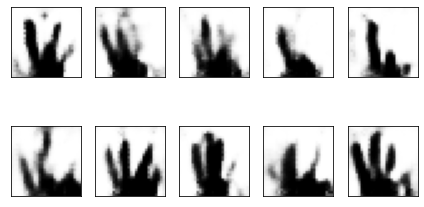


Epoch 42/50
epoch = 42/50, d_loss=0.266, g_loss=2.366                                                                                                     

Epoch 43/50
epoch = 43/50, d_loss=0.449, g_loss=1.860                                                                                                     

Epoch 44/50
epoch = 44/50, d_loss=0.459, g_loss=2.604                                                                                                     

Epoch 45/50
epoch = 45/50, d_loss=0.486, g_loss=2.372                                                                                                     

Epoch 46/50
epoch = 46/50, d_loss=0.578, g_loss=1.875                                                                                                     
1/1 [==============================] - 0s 13ms/step


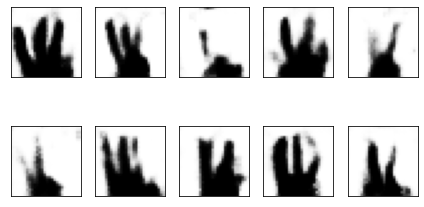


Epoch 47/50
epoch = 47/50, d_loss=0.421, g_loss=2.231                                                                                                     

Epoch 48/50
epoch = 48/50, d_loss=0.226, g_loss=2.619                                                                                                     

Epoch 49/50
epoch = 49/50, d_loss=0.396, g_loss=2.756                                                                                                     

Epoch 50/50
epoch = 50/50, d_loss=0.356, g_loss=2.476                                                                                                     


In [ ]:

# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

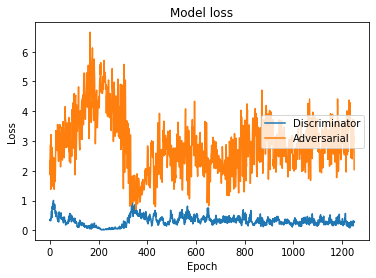

In [ ]:
plt.plot(D_loss)
plt.plot(G_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

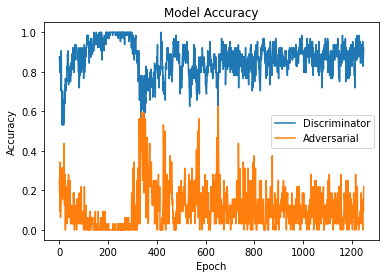

In [ ]:
plt.plot(D_acc)
plt.plot(G_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()